# Student Admission Classification with Logistic Regression

- Goal: Predict whether a student gets admitted to university based on exam scores.


- Algorithm: Logistic Regression

- Steps:

In [53]:
# imports 

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

Load the dataset and visualize the relationship between features and labels.

In [27]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("amanace/student-admission-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\bbuser\.cache\kagglehub\datasets\amanace\student-admission-dataset\versions\1


In [28]:
import os

print("Dataset files:", os.listdir(path))


Dataset files: ['student_admission_dataset.csv']


In [29]:
csv_path = os.path.join(path, "student_admission_dataset.csv")
df = pd.read_csv(csv_path)

df.head()

,GPA,SAT_Score,Extracurricular_Activities,Admission_Status
0,3.46,1223,8,Rejected
1,2.54,974,8,Rejected
2,2.91,909,9,Rejected
3,2.83,1369,5,Accepted
4,3.60,1536,7,Accepted


In [30]:
df.shape

(250, 4)

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 4 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   GPA                         250 non-null    float64
 1   SAT_Score                   250 non-null    int64  
 2   Extracurricular_Activities  250 non-null    int64  
 3   Admission_Status            250 non-null    object 
dtypes: float64(1), int64(2), object(1)
memory usage: 7.9+ KB


In [32]:
df.isnull().sum()

GPA                           0
SAT_Score                     0
Extracurricular_Activities    0
Admission_Status              0
dtype: int64

In [33]:
df.duplicated().sum()

np.int64(0)

In [34]:
df["Admission_Status"].value_counts()

Admission_Status
Waitlisted    88
Rejected      81
Accepted      81
Name: count, dtype: int64

In [35]:
df["Extracurricular_Activities"].value_counts()

Extracurricular_Activities
7     30
6     29
3     26
5     25
4     25
9     23
8     21
1     19
10    19
0     18
2     15
Name: count, dtype: int64

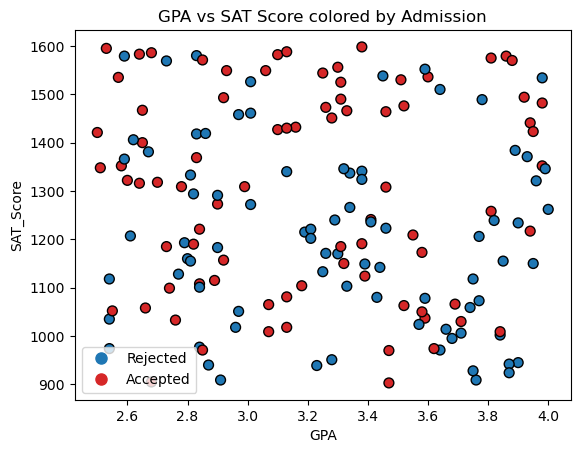

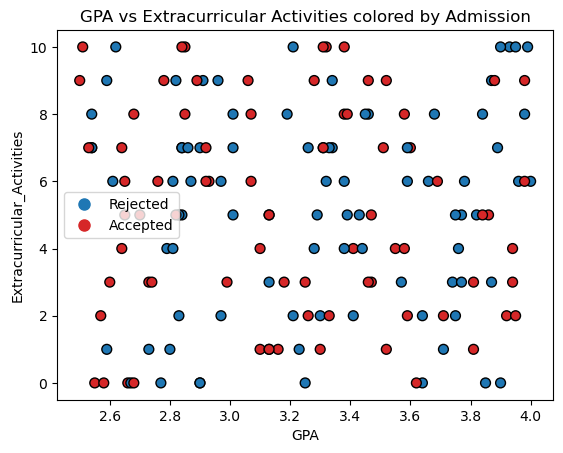

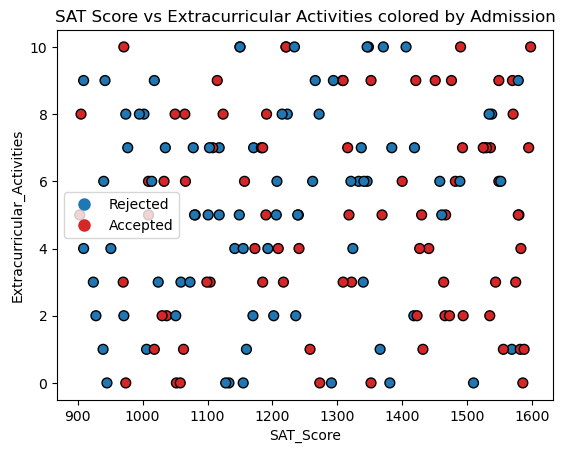

In [45]:
cmap_br = ListedColormap(["#1f77b4", "#d62728"])  # blue, red
def legend_blue_red():
    rejected = mlines.Line2D([], [], color="#1f77b4", marker="o",
                             linestyle="None", markersize=8, label="Rejected")
    accepted = mlines.Line2D([], [], color="#d62728", marker="o",
                             linestyle="None", markersize=8, label="Accepted")
    plt.legend(handles=[rejected, accepted])

# ---------- 3) Quick EDA scatter plots (with legend) ----------
def scatter_with_legend(xcol, ycol, title):
    plt.scatter(df[xcol], df[ycol], c=df["Admission_Status"],
                cmap=cmap_br, edgecolors="k", s=50, vmin=0, vmax=1)
    plt.xlabel(xcol)
    plt.ylabel(ycol)
    plt.title(title)
    legend_blue_red()
    plt.show()

scatter_with_legend("GPA", "SAT_Score", "GPA vs SAT Score colored by Admission")
scatter_with_legend("GPA", "Extracurricular_Activities",
                    "GPA vs Extracurricular Activities colored by Admission")
scatter_with_legend("SAT_Score", "Extracurricular_Activities",
                    "SAT Score vs Extracurricular Activities colored by Admission")


Train a logistic regression model.

In [54]:
encoder = LabelEncoder()
df['Admission_Status'] = encoder.fit_transform(df['Admission_Status'])

In [55]:
#preparing for modelling
X = df[['GPA', 'SAT_Score', 'Extracurricular_Activities']]
y = df['Admission_Status']

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)   
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train) 
X_test = scaler.transform(X_test)
#model
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [57]:
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.34


Plot the decision boundary.

c:\Users\bbuser\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


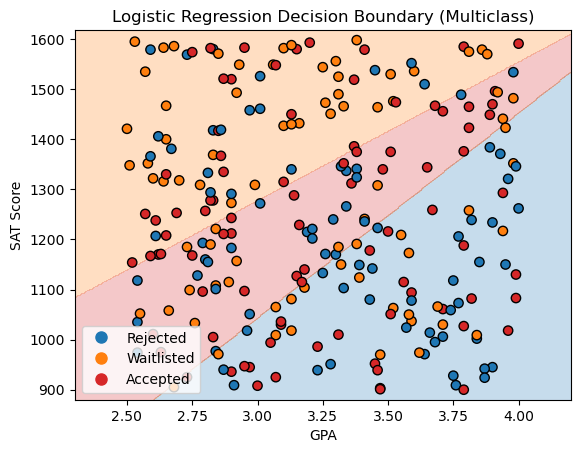

In [59]:
# Colors: 0=blue, 1=orange, 2=red (we'll map these to encoder.classes_)
cmap3 = ListedColormap(["#1f77b4", "#ff7f0e", "#d62728"])

# Choose which two features to visualize
ix_gpa  = 0  # column index of GPA in X
ix_sat  = 1  # column index of SAT_Score in X
ix_extra = 2 # Extracurricular_Activities (will be fixed at its median)

# Grid over GPA & SAT ranges
x_min, x_max = X.iloc[:, ix_gpa].min() - 0.2, X.iloc[:, ix_gpa].max() + 0.2
y_min, y_max = X.iloc[:, ix_sat].min() - 20,  X.iloc[:, ix_sat].max() + 20
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 400),
    np.linspace(y_min, y_max, 400)
)

# Fix Extracurricular_Activities at its training median
extra_med = np.median(X.iloc[:, ix_extra].iloc[y_train.index]) if hasattr(y_train, "index") else np.median(X_train[:, ix_extra])
# Build a 3-feature grid to match the trained scaler/model
grid_raw = np.c_[xx.ravel(), yy.ravel(), np.full(xx.size, extra_med)]

# IMPORTANT: transform with the SAME scaler, then predict
grid_scaled = scaler.transform(grid_raw)
Z = model.predict(grid_scaled).reshape(xx.shape)

# Plot decision regions
plt.contourf(xx, yy, Z, alpha=0.25, cmap=cmap3, levels=[-0.5,0.5,1.5,2.5])

# Scatter original points (use raw GPA & SAT; color by encoded y)
plt.scatter(X.iloc[:, ix_gpa], X.iloc[:, ix_sat], c=y,
            cmap=cmap3, edgecolors="k", s=45, vmin=0, vmax=2)

plt.xlabel("GPA")
plt.ylabel("SAT Score")
plt.title("Logistic Regression Decision Boundary (Multiclass)")

# Legend that matches encoder classes -> numeric codes used by LabelEncoder
class_to_code = {cls: i for i, cls in enumerate(encoder.classes_)}
legend_handles = [
    mlines.Line2D([], [], color=cmap3(class_to_code.get("Rejected",0)),  marker="o", linestyle="None", markersize=8, label="Rejected"),
    mlines.Line2D([], [], color=cmap3(class_to_code.get("Waitlisted",1)),marker="o", linestyle="None", markersize=8, label="Waitlisted"),
    mlines.Line2D([], [], color=cmap3(class_to_code.get("Accepted",2)),  marker="o", linestyle="None", markersize=8, label="Accepted"),
]
plt.legend(handles=legend_handles)
plt.show()


Evaluate performance (accuracy, confusion matrix).

In [62]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report


Accuracy: 0.3400



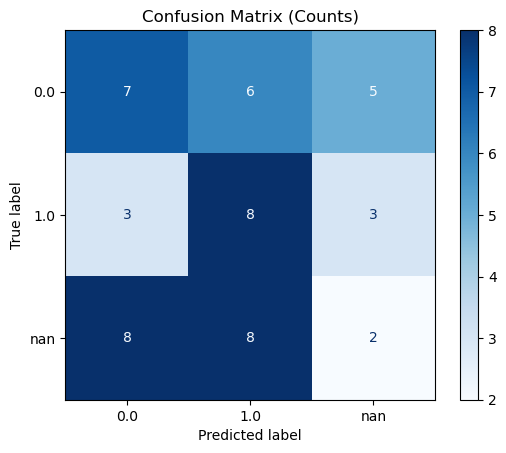

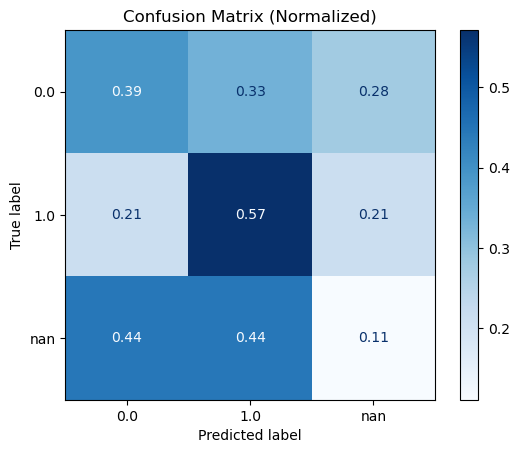

Classification report:
              precision    recall  f1-score   support

         0.0       0.39      0.39      0.39        18
         1.0       0.36      0.57      0.44        14
         nan       0.20      0.11      0.14        18

    accuracy                           0.34        50
   macro avg       0.32      0.36      0.33        50
weighted avg       0.31      0.34      0.32        50



In [66]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np
import matplotlib.pyplot as plt

# Predictions
y_pred = model.predict(X_test)

# Keep label order consistent with what the model saw
labels = np.unique(y_test)  # e.g., [0,1,2]

# Map codes -> class names (force strings to avoid the TypeError)
idx_to_name = {i: str(c) for i, c in enumerate(encoder.classes_)}
target_names = [idx_to_name[i] for i in labels]

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}\n")

# Confusion matrix (counts)
cm = confusion_matrix(y_test, y_pred, labels=labels)
ConfusionMatrixDisplay(cm, display_labels=target_names).plot(cmap="Blues")
plt.title("Confusion Matrix (Counts)")
plt.show()

# Normalized confusion matrix (per-class recall)
cmn = confusion_matrix(y_test, y_pred, labels=labels, normalize="true")
ConfusionMatrixDisplay(cmn, display_labels=target_names).plot(cmap="Blues", values_format=".2f")
plt.title("Confusion Matrix (Normalized)")
plt.show()

# Classification report
print("Classification report:")
print(classification_report(y_test, y_pred,
                            labels=labels,
                            target_names=target_names,
                            zero_division=0))
